## Домашнее задание: "Детекция объектов на изображении"

ФИО: Яргин Захар Максимович

## Цель задания:
Научиться самостоятельно решать задачу детекции.
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу детекции мячей и настроить полный пайплайн обучения модели.

Процесс выполнения задания следующий:

0. Выбор модели детекции для обучения:
    1. Выберите модель детекции для выполнения домашнего задания. Любую, кроме RetinaNet. Ее реализацию можно взять из открытых источников. Модель можно брать предобученную ( в этом случае в пункте 4. показать влияние предобучения на финальное качество).
    2. Полезные ссылки: [PyTorch Vision Models](https://pytorch.org/vision/stable/models.html) (блок Object Detection), [SOTA модели детекции](https://paperswithcode.com/sota/object-detection-on-coco), [Возможный пример кода](https://github.com/AlekseySpasenov/dl-course/blob/autumn_2023/lecture8/detection_example/pytorch_detection_workshop.ipynb)
    3. Вы можете использовать RetinaNet, которая была реализована на семинаре, но это приведет к снижению оценки на **–2.5 балла**, так как задания 1.1 и 2.1 уже были выполнены в рамках занятия.

1. Подготовка обучающего набора данных
    0. Для выполнения задания используйте датасет с изображениями мячей, который использовался на семинаре.
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера) **0.5 балла**.
    2. Добавьте простые аугментации в датасет (аугментации, не затрагивающие изменение ground-truth bounding box) **0.5 балла**.
    3. Внедрите сложные аугментации (аугментации, затрагивающие изменение ground-truth bounding box. Например, аффинные преобразования: сдвиг, поворот и т.д.) **0.5 балла**.

    4. Полезные ссылки: https://pytorch.org/vision/stable/transforms.html , https://albumentations.ai

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте эффективный train-loop для вашей модели и проведите обучение **2 балла**.
    2. Выполните несколько запусков обучения с различными параметрами, например: сравните влияние различных аугментаций, оцените влияние того была предобучена модель или нет, сравните результаты при изменении гиперпараметров итд (на ваш выбор) **0.5 балла**.

3. Валидация обученных моделей на тестовой выборке, вычисление метрики mAP
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрику mAP **0.5 балл**
    2. Полезные ссылки: [mean_average_precision](https://github.com/bes-dev/mean_average_precision)

4. Выводы **0.5 балл**:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.

In [39]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json
import torchvision
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision.transforms import v2
from torchvision import transforms
import tqdm

%matplotlib inline

In [36]:
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, transforms=None):
        self.transforms = transforms
        
        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        
        self.imgs = list(self.data_dict.keys())
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        num_objs = len(self.data_dict[img_path])
        boxes = []
        for i in range(num_objs):
            bbox = self.data_dict[img_path][i]
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        image_id = torch.tensor([idx])
    
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [8]:
#!gdown "https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF" -O seminar_objdet_retina_oi5_ball.zip

In [9]:
# simple_transforms = transforms.Compose([
#     transforms.ColorJitter(brightness=0.3, contrast=0.3),  # яркость и контраст
#     transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # резкость
#     transforms.RandomGrayscale(p=0.1),  # иногда ч/б
#     transforms.ToTensor(),
# ])
img_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [10]:
train_dataset = DetectionDataset('oi5_ball_filename_to_bbox_train.json', img_transforms)
val_dataset = DetectionDataset('oi5_ball_filename_to_bbox_val.json', img_transforms)

In [11]:
def show_image(image, figsize=(4, 4)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

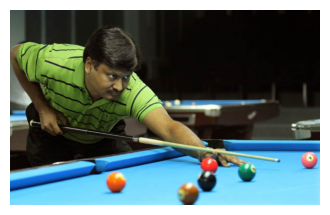

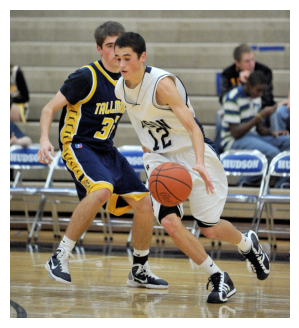

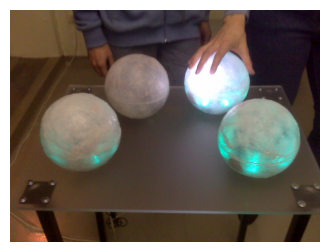

In [12]:
iterator = iter(train_dataset)
exp_img, exp_terget = next(iterator)
show_image(exp_img.permute(1,2,0).numpy())
exp_img, exp_terget = next(iterator)
show_image(exp_img.permute(1,2,0).numpy())
exp_img, exp_terget = next(iterator)
show_image(exp_img.permute(1,2,0).numpy())

In [13]:
gray_img = v2.Grayscale()(train_dataset[2])

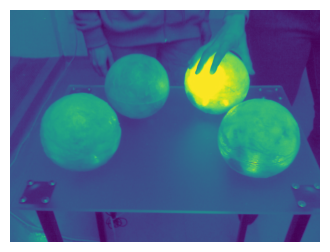

In [14]:
iterator = iter(gray_img)
exp_img = next(iterator)
show_image(exp_img.permute(1,2,0).numpy())

In [15]:
jitter = v2.ColorJitter(brightness=1, contrast = 0.1, hue=0.1)(train_dataset[2])

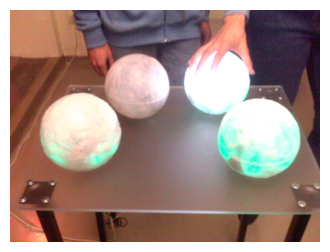

In [16]:
iterator = iter(jitter)
exp_img = next(iterator)
show_image(exp_img.permute(1,2,0).numpy())

In [17]:
rotater = v2.RandomRotation(degrees=(0, 45))(train_dataset[2])

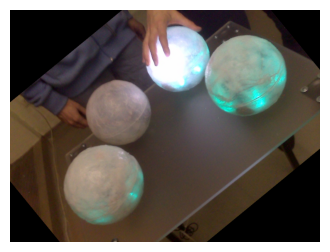

In [18]:
iterator = iter(rotater)
exp_img = next(iterator)
show_image(exp_img.permute(1,2,0).numpy())

In [19]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.2, p=1)(train_dataset[2])

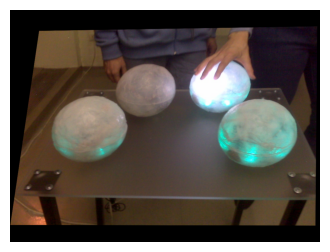

In [20]:
iterator = iter(perspective_transformer)
exp_img = next(iterator)
show_image(exp_img.permute(1,2,0).numpy())

## Make dataloaders

In [44]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [51]:
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn, drop_last=True)

data_loader_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, num_workers=0,
    collate_fn=collate_fn, drop_last=False)

## Load model

In [24]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [25]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                             progress=True,
                                                             num_classes=91, 
                                                             pretrained_backbone=True
                                                            )
model.roi_heads.box_predictor

C:\Games\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Games\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Games\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Games\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'we

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [26]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Включить обучение только region-proposal сети и головы

In [52]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


for param in model.parameters():
    param.requires_grad = True
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True
    
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [53]:
model.to(device);

In [54]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.body.conv1.weight
backbone.body.layer1.0.conv1.weight
backbone.body.layer1.0.conv2.weight
backbone.body.layer1.0.conv3.weight
backbone.body.layer1.0.downsample.0.weight
backbone.body.layer1.1.conv1.weight
backbone.body.layer1.1.conv2.weight
backbone.body.layer1.1.conv3.weight
backbone.body.layer1.2.conv1.weight
backbone.body.layer1.2.conv2.weight
backbone.body.layer1.2.conv3.weight
backbone.body.layer2.0.conv1.weight
backbone.body.layer2.0.conv2.weight
backbone.body.layer2.0.conv3.weight
backbone.body.layer2.0.downsample.0.weight
backbone.body.layer2.1.conv1.weight
backbone.body.layer2.1.conv2.weight
backbone.body.layer2.1.conv3.weight
backbone.body.layer2.2.conv1.weight
backbone.body.layer2.2.conv2.weight
backbone.body.layer2.2.conv3.weight
backbone.body.layer2.3.conv1.weight
backbone.body.layer2.3.conv2.weight
backbone.body.layer2.3.conv3.weight
backbone.body.layer3.0.conv1.weight
backbone.body.layer3.0.conv2.weight
backbone.body.layer3.0.conv3.weight
backbone.body.layer3.0.

In [55]:
len(params)

83

In [56]:
for param in model.parameters():
    param.requires_grad = True

In [57]:
len(params)

83

In [58]:
import math
import sys
import time
import torch

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    for images, targets in tqdm(data_loader):  # убрать .tqdm_notebook
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum([value for value in loss_dict.values()])
        loss_value = losses.item()
        
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(loss_value)

In [59]:
from tqdm import tqdm

num_epochs = 1
for epoch in tqdm(range(num_epochs)):
    train_one_epoch(model, optimizer, data_loader, device)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


  0%|                                                                                         | 0/1437 [00:00<?, ?it/s]


  0%|                                                                               | 1/1437 [00:13<5:30:35, 13.81s/it]


  0%|                                                                               | 2/1437 [00:29<5:56:29, 14.91s/it]


  0%|                                                                                            | 0/1 [01:02<?, ?it/s]
Exception ignored in: <function tqdm.__del__ at 0x000001F95F9996C0>
Traceback (most recent call last):
  File "C:\Games\python\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Games\python\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no 

KeyboardInterrupt: 

In [89]:
import seaborn as sns
to_tensor = transforms.ToTensor()

def val_transform(img):
    img_tensor = to_tensor(img)
    return img_tensor.unsqueeze(0)

# def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
#                                n_colors=None, id_to_name=None):
def visualize_prediction_plate(file, model,verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = val_transform(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.to(device)) # list of size 1
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        name = id_to_name[label]
        color = palette[label]
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:
            image = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            cv2.putText(image, name, (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
    show_image(image)
    return prediction

In [90]:
def load_from_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)
        
filename_to_bbox_val_dict = load_from_json('oi5_ball_filename_to_bbox_val.json')

In [91]:
val_filenames = list(filename_to_bbox_val_dict.keys())

In [92]:
filename = np.random.choice(val_filenames)

In [93]:
filename = np.random.choice(val_filenames)
visualize_prediction_plate(filename, model, id_to_name={1: 'plate'}, thresh=0.5)

Class: plate, Confidence: 0.9905892610549927
Class: plate, Confidence: 0.990393340587616


KeyError: 37